## Load packages + data

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from scipy.stats import pearsonr
from sklearn.frozen import FrozenEstimator
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


### reading data

In [2]:
chunksize = 100

list_of_dataframes = []

for df in pd.read_csv('MeanImputedScaledData.csv', chunksize=chunksize, index_col=0):
    list_of_dataframes.append(df)

result = pd.concat(list_of_dataframes)
df = result

ax_columns = [col for col in df.columns if col.startswith('AX')]
# len(ax_columns)
X = df[ax_columns]
y = df["Status"]
X = X.to_numpy()
y = y.to_numpy()

scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-0.81812574, -0.76982067, -0.02041218, ...,  0.        ,
         0.        ,  0.        ],
       [-0.81812574, -0.76982067, -0.02041218, ...,  0.        ,
         0.        ,  0.        ],
       [-0.81812574, -0.76982067, -0.02041218, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.81812574, -0.76982067, -0.02041218, ...,  0.        ,
         0.        ,  0.        ],
       [-0.81812574, -0.76982067, -0.02041218, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.90392783,  2.18940958, -0.02041218, ...,  0.        ,
         0.        ,  0.        ]])

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

## predict proba

### LR/GB/RF first pass

In [5]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_probs = lr_model.predict_proba(X_test)
print("\nLogistic Regression Probabilities:\n", lr_probs)

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
gb_probs = gb_model.predict_proba(X_test)
print("Gradient Boosting Probabilities:\n", gb_probs)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_probs = rf_model.predict_proba(X_test)
print("\nRandom Forest Probabilities:\n", rf_probs)



Logistic Regression Probabilities:
 [[1.84671139e-03 9.98153289e-01]
 [1.20882052e-06 9.99998791e-01]
 [2.19739667e-01 7.80260333e-01]
 ...
 [2.90755619e-07 9.99999709e-01]
 [1.35696387e-07 9.99999864e-01]
 [8.66695999e-03 9.91333040e-01]]
Gradient Boosting Probabilities:
 [[0.38311932 0.61688068]
 [0.7361797  0.2638203 ]
 [0.17926464 0.82073536]
 ...
 [0.33889658 0.66110342]
 [0.08192517 0.91807483]
 [0.32330675 0.67669325]]

Random Forest Probabilities:
 [[0.35 0.65]
 [0.46 0.54]
 [0.32 0.68]
 ...
 [0.37 0.63]
 [0.24 0.76]
 [0.49 0.51]]


#### optional (?) calibration

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_calib, y_train, y_calib = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# --- Logistic Regression ---
lr_base = LogisticRegression(max_iter=1000, random_state=42)
lr_base.fit(X_train, y_train)
lr_frozen = FrozenEstimator(lr_base)
lr_calibrated = CalibratedClassifierCV(lr_frozen, cv=3, method='sigmoid')
lr_calibrated.fit(X_calib, y_calib)
lr_probs_cal = lr_calibrated.predict_proba(X_test)
print("\nCalibrated Logistic Regression Probabilities:\n", lr_probs_cal)

# --- Gradient Boosting ---
gb_base = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_base.fit(X_train, y_train)
gb_frozen = FrozenEstimator(gb_base)
gb_calibrated = CalibratedClassifierCV(gb_frozen, cv=3, method='sigmoid')
gb_calibrated.fit(X_calib, y_calib)
gb_probs_cal = gb_calibrated.predict_proba(X_test)
print("\nCalibrated Gradient Boosting Probabilities:\n", gb_probs_cal)

# --- Random Forest ---
rf_base = RandomForestClassifier(n_estimators=100, random_state=42)
rf_base.fit(X_train, y_train)
rf_frozen = FrozenEstimator(rf_base)
rf_calibrated = CalibratedClassifierCV(rf_frozen, cv=3, method='sigmoid')
rf_calibrated.fit(X_calib, y_calib)
rf_probs_cal = rf_calibrated.predict_proba(X_test)
print("\nCalibrated Random Forest Probabilities:\n", rf_probs_cal)


#### figures for calibrated data

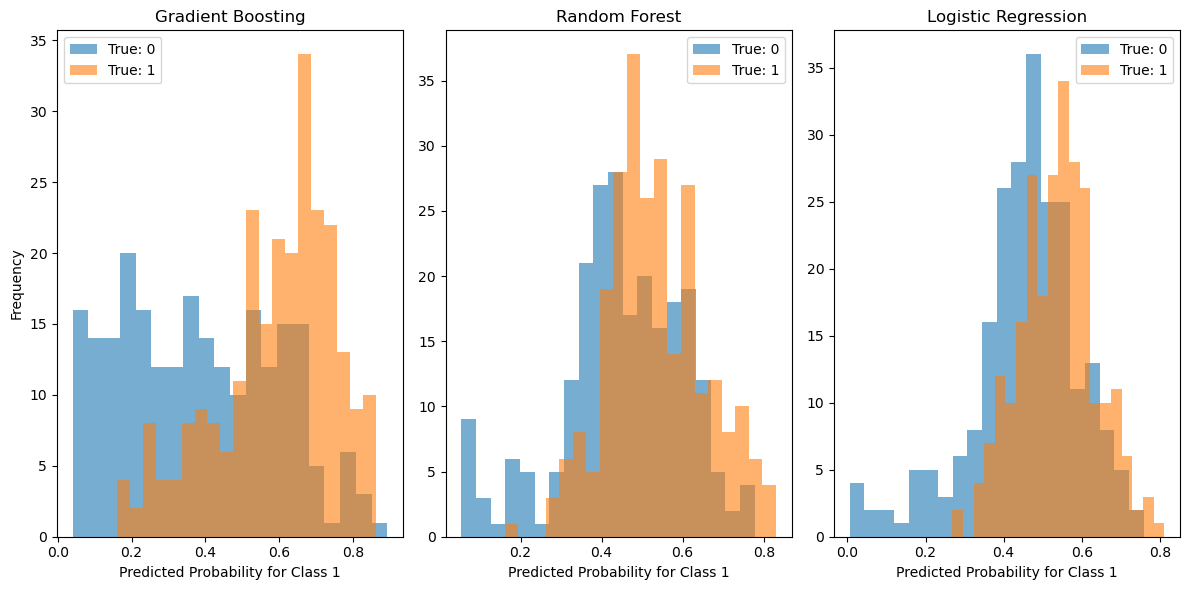

In [10]:
gb_class1_probs = gb_probs_cal[:, 1]
rf_class1_probs = rf_probs_cal[:, 1]
lr_class1_probs = lr_probs_cal[:, 1]

plt.figure(figsize=(12, 6))

# Gradient Boosting
plt.subplot(1, 3, 1)
plt.hist(gb_class1_probs[y_test == 0], bins=20, alpha=0.6, label='True: 0')
plt.hist(gb_class1_probs[y_test == 1], bins=20, alpha=0.6, label='True: 1')
plt.title('Gradient Boosting')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Frequency')
plt.legend()

# Random Forest
plt.subplot(1, 3, 2)
plt.hist(rf_class1_probs[y_test == 0], bins=20, alpha=0.6, label='True: 0')
plt.hist(rf_class1_probs[y_test == 1], bins=20, alpha=0.6, label='True: 1')
plt.title('Random Forest')
plt.xlabel('Predicted Probability for Class 1')
plt.legend()

# Logistic Regression
plt.subplot(1, 3, 3)
plt.hist(lr_class1_probs[y_test == 0], bins=20, alpha=0.6, label='True: 0')
plt.hist(lr_class1_probs[y_test == 1], bins=20, alpha=0.6, label='True: 1')
plt.title('Logistic Regression')
plt.xlabel('Predicted Probability for Class 1')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
## Plot vs true label
from scipy.stats import pearsonr
lr_corr, _ = pearsonr(lr_class1_probs, y_test)
gb_corr, _ = pearsonr(gb_class1_probs, y_test)
rf_corr, _ = pearsonr(rf_class1_probs, y_test)

print(f"Pearson Correlation (Calibrated Logistic Regression): {lr_corr:.4f}")
print(f"Pearson Correlation (Calibrated Gradient Boosting): {gb_corr:.4f}")
print(f"Pearson Correlation (Calibrated Random Forest): {rf_corr:.4f}")


Pearson Correlation (Calibrated Logistic Regression): 0.3332
Pearson Correlation (Calibrated Gradient Boosting): 0.4928
Pearson Correlation (Calibrated Random Forest): 0.2989


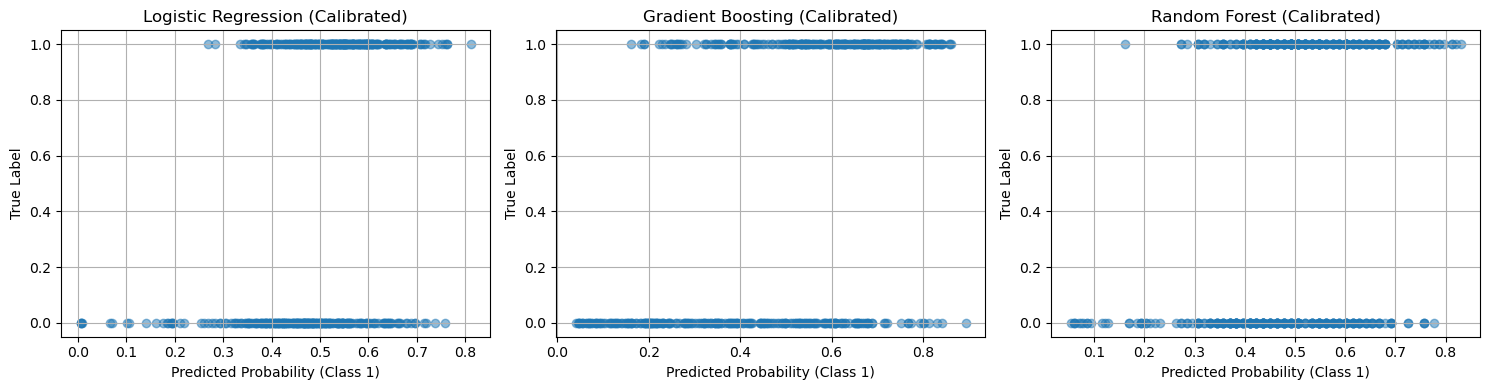

In [13]:
plt.figure(figsize=(15, 4))

# Logistic Regression
plt.subplot(1, 3, 1)
plt.scatter(lr_class1_probs, y_test, alpha=0.5)
plt.title('Logistic Regression (Calibrated)')
plt.xlabel('Predicted Probability (Class 1)')
plt.ylabel('True Label')
plt.grid(True)

# Gradient Boosting
plt.subplot(1, 3, 2)
plt.scatter(gb_class1_probs, y_test, alpha=0.5)
plt.title('Gradient Boosting (Calibrated)')
plt.xlabel('Predicted Probability (Class 1)')
plt.ylabel('True Label')
plt.grid(True)

# Random Forest
plt.subplot(1, 3, 3)
plt.scatter(rf_class1_probs, y_test, alpha=0.5)
plt.title('Random Forest (Calibrated)')
plt.xlabel('Predicted Probability (Class 1)')
plt.ylabel('True Label')
plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
gb_probs_df = pd.DataFrame(gb_probs_cal, columns=['prob_class_0', 'prob_class_1'])
gb_probs_df['true_label'] = y_test
# gb_probs_df

gb_preds = np.argmax(gb_probs_cal, axis=1)
accuracy = accuracy_score(y_test, gb_preds)
accuracy

0.7257731958762886

### MLP first pass

In [19]:
mlp = MLPClassifier(hidden_layer_sizes=(113,),
                    max_iter=33,
                    learning_rate_init=0.08,
                    solver='sgd',
                    batch_size=150,
                    random_state=42)
mlp.fit(X_train, y_train)

mlp_frozen = FrozenEstimator(mlp)

mlp_calibrated = CalibratedClassifierCV(estimator=mlp_frozen, cv=3, method='sigmoid')
mlp_calibrated.fit(X_calib, y_calib)
mlp_probs_cal = mlp_calibrated.predict_proba(X_test)

mlp_preds = np.argmax(mlp_probs_cal, axis=1)
accuracy = accuracy_score(y_test, mlp_preds)

print("Calibrated MLP Probabilities:\n", mlp_probs_cal[:5])
print(f"\nAccuracy on test set: {accuracy:.4f}")


Calibrated MLP Probabilities:
 [[0.51059309 0.48940691]
 [0.49759892 0.50240108]
 [0.49759892 0.50240108]
 [0.51059309 0.48940691]
 [0.49759892 0.50240108]]

Accuracy on test set: 0.5216


### 10 fold CV with calibration for GB

In [4]:
## rerun 8/1

outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_accuracies = []
gebv_records = []

for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    X_train_outer, X_test_outer = X[train_idx], X[test_idx]
    y_train_outer, y_test_outer = y[train_idx], y[test_idx]
    
    gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gb_model.fit(X_train_outer, y_train_outer)
    gb_frozen = FrozenEstimator(gb_model)
    
    calibrated_gb = CalibratedClassifierCV(estimator=gb_frozen, cv=3, method='sigmoid')
    calibrated_gb.fit(X_train_outer, y_train_outer) 
    
    y_probs = calibrated_gb.predict_proba(X_test_outer)
    y_preds = np.argmax(y_probs, axis=1)
    acc = accuracy_score(y_test_outer, y_preds)
    fold_accuracies.append(acc)
    
    for i, prob in zip(test_idx, y_probs[:, 1]):
        gebv_records.append({
            'fold': fold_idx,
            'sample_index': i,
            'true_label': y[i],
            'gebv': prob  # class 1 probability
        })

    print(f"Fold {fold_idx}: Accuracy = {acc:.4f}")

print("\nAverage Accuracy over 10 folds:", np.mean(fold_accuracies))
print("Standard Deviation:", np.std(fold_accuracies))


Fold 1: Accuracy = 0.7202
Fold 2: Accuracy = 0.7243
Fold 3: Accuracy = 0.7202
Fold 4: Accuracy = 0.7438
Fold 5: Accuracy = 0.7107
Fold 6: Accuracy = 0.6570
Fold 7: Accuracy = 0.7025
Fold 8: Accuracy = 0.7066
Fold 9: Accuracy = 0.7025
Fold 10: Accuracy = 0.7273

Average Accuracy over 10 folds: 0.7115022276638439
Standard Deviation: 0.021818368684391062


In [6]:
fold_accuracies = []
gebv_records = []

for trial_idx in range(10):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=trial_idx
    )
    X_train, X_calib, y_train, y_calib = train_test_split(
        X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=trial_idx
    )
    gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gb_model.fit(X_train, y_train)

    gb_frozen = FrozenEstimator(gb_model)
    calibrated_gb = CalibratedClassifierCV(estimator=gb_frozen, method='sigmoid')
    calibrated_gb.fit(X_calib, y_calib)

    y_probs = calibrated_gb.predict_proba(X_test)
    y_preds = np.argmax(y_probs, axis=1)
    acc = accuracy_score(y_test, y_preds)
    fold_accuracies.append(acc)

    for i, prob in zip(X_test, y_probs[:, 1]):
        gebv_records.append({
            'trial': trial_idx,
            'true_label': y_test[np.where((X_test == i).all(axis=1))[0][0]],
            'gebv': prob
        })

    print(f"Trial {trial_idx}: Accuracy = {acc:.4f}")

print("\nAverage Accuracy over 10 trials:", np.mean(fold_accuracies))
print("Standard Deviation:", np.std(fold_accuracies))
gebv_df = pd.DataFrame(gebv_records)
print("\nGEBV Predictions Preview:")
print(gebv_df.head())
gebv_df.to_csv("gebv_df_GB.csv")
gebv_df

Trial 0: Accuracy = 0.7361
Trial 1: Accuracy = 0.7340
Trial 2: Accuracy = 0.6784
Trial 3: Accuracy = 0.7010
Trial 4: Accuracy = 0.6907
Trial 5: Accuracy = 0.7031
Trial 6: Accuracy = 0.6804
Trial 7: Accuracy = 0.6784
Trial 8: Accuracy = 0.6701
Trial 9: Accuracy = 0.7175

Average Accuracy over 10 trials: 0.6989690721649484
Standard Deviation: 0.022511082992092667

GEBV Predictions Preview:
   trial  true_label      gebv
0      0         1.0  0.653281
1      0         0.0  0.605342
2      0         1.0  0.666208
3      0         0.0  0.372904
4      0         0.0  0.086489


trial  true_label      gebv
0         0         1.0  0.653281
1         0         0.0  0.605342
2         0         1.0  0.666208
3         0         0.0  0.372904
4         0         0.0  0.086489
...     ...         ...       ...
4845      9         1.0  0.710450
4846      9         0.0  0.458932
4847      9         0.0  0.612465
4848      9         0.0  0.465401
4849      9         1.0  0.648046

[4850 rows x 3 columns]

In [7]:
# plt.subplot(1, 3, 2)
# plt.scatter(gebv_records["gebv"], gebv_records["true_label"], alpha=0.5)
# plt.title('Gradient Boosting (Calibrated)')
# plt.xlabel('Predicted Probability (Class 1)')
# plt.ylabel('True Label')
# plt.grid(True)
# plt.show()

gb_corr_cv, _ = pearsonr(gebv_df["gebv"], gebv_df["true_label"])
print(f"Pearson Correlation (Calibrated 10 Fold Gradient Boosting): {gb_corr_cv:.4f}")

Pearson Correlation (Calibrated 10 Fold Gradient Boosting): 0.4656


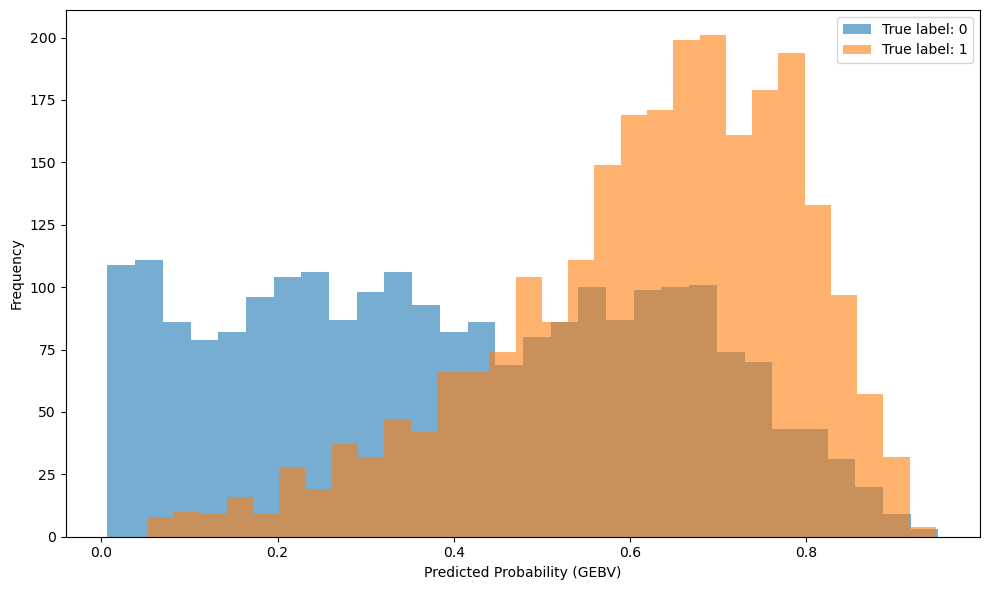

In [11]:
plt.figure(figsize=(10,6))
plt.hist(gebv_df[gebv_df['true_label'] == 0]['gebv'], bins=30, alpha=0.6, label='True label: 0')
plt.hist(gebv_df[gebv_df['true_label'] == 1]['gebv'], bins=30, alpha=0.6, label='True label: 1')

# plt.title('Histogram of Predicted GEBVs vs True Class')
plt.xlabel('Predicted Probability (GEBV)')
plt.ylabel('Frequency')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()